## 1. Data pre-processing and feature selection

#### Import Python libraries used in this Notebook

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


%matplotlib inline

In [151]:
#Read the data
df = pd.read_csv("data.csv")

In [152]:
#Drop Unnamed: 32 and ID columns
df = df.drop(["Unnamed: 32", "id"], axis=1)

In [153]:
#No nulls 
#df.info()

In [154]:
#Check if there is class mis- or overrepresentation
print("Percentage of Benign cases in the data:", round(df.diagnosis.value_counts()[0]/(df.diagnosis.size),3)*100,'%')
print("Percentage of Malignant cases in the data:", round(df.diagnosis.value_counts()[1]/(df.diagnosis.size),3)*100,"%")

Percentage of Benign cases in the data: 62.7 %
Percentage of Malignant cases in the data: 37.3 %


In [155]:
#Replace M and B with 1 and 0 
df = df.replace("M",1)
df = df.replace("B",0)

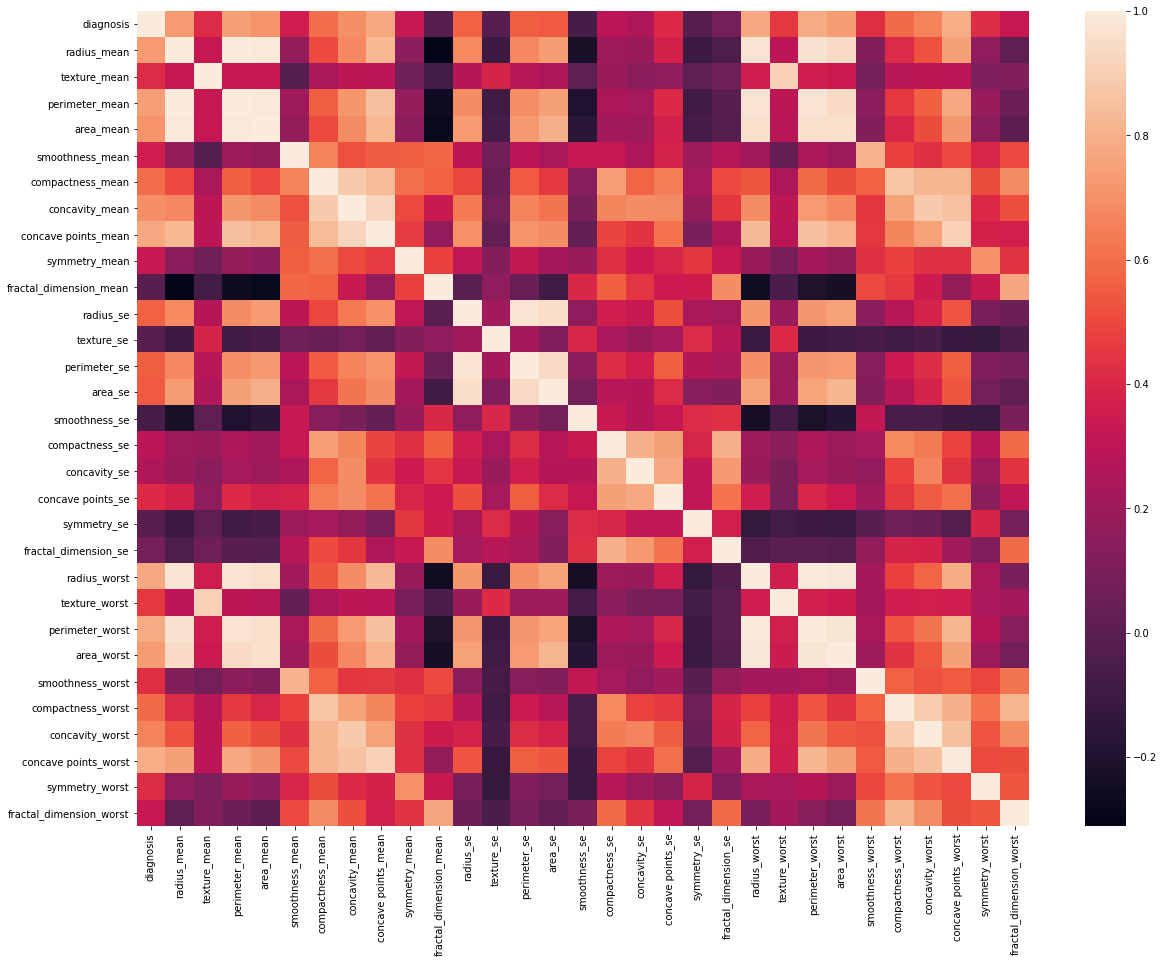

In [156]:
#Plot correlation matrix => some variables are highly correlated 
plt.figure(figsize = (20,15))
correlation_matrix = df.corr()
sns.heatmap(data = correlation_matrix, annot = False)

#### Split data into training and test sets and normalize

In [110]:
df.loc[df['diagnosis'] == 'B', 'diagnosis'] = 0
df.loc[df['diagnosis'] == 'M', 'diagnosis'] = 1
df['diagnosis'] = df['diagnosis'].astype(int)
y = df['diagnosis']

/Users/Aga/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


TypeError: invalid type comparison

In [177]:
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']

lab_enc = preprocessing.LabelEncoder()
y = lab_enc.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [178]:
#Normalise training set 
scale = StandardScaler().fit(X_train) 
X_train_normal = scale.transform(X_train)
X_test_normal = scale.transform(X_test)

#### PCA - feature selection

In [179]:
pca = PCA(n_components=X_train_normal.shape[1]).fit(X_train_normal)

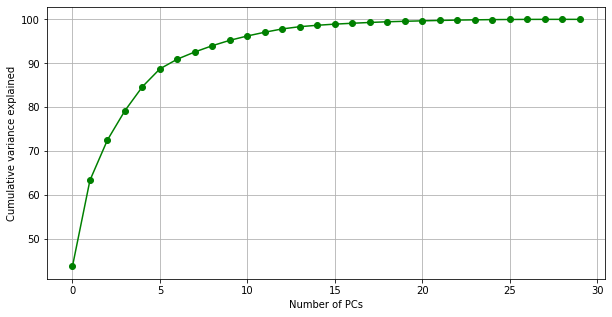

In [180]:
#Cumulative Variance Explained
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.figure(figsize = (10,5))
plt.plot(var1, 'go-')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative variance explained')
plt.grid()

In [181]:
#Looking at above plot I'm taking 14 PCs
pca = PCA(n_components=10).fit(X_train_normal)
X_train_pca = pca.transform(X_train_normal)
X_test_pca = pca.transform(X_test_normal)

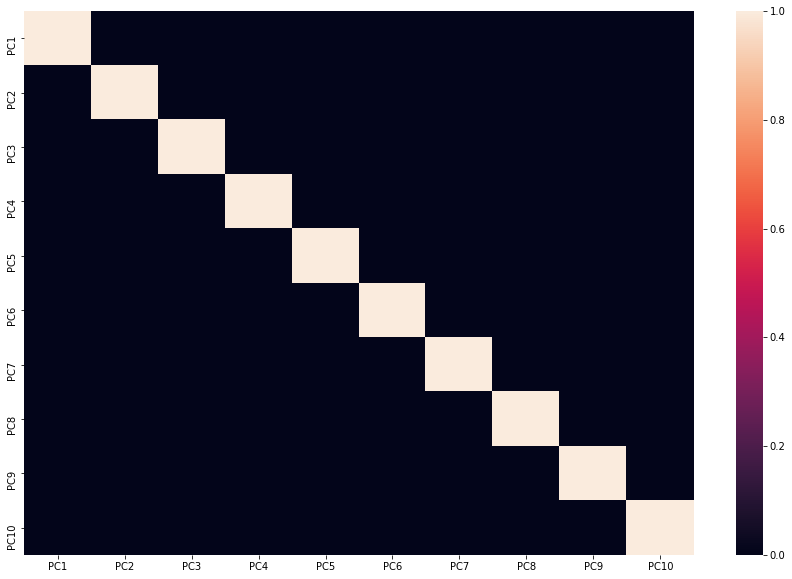

In [182]:
#There is no correlation between the new PC components 
features_pca = ['PC'+str(i+1) for i in range(pca.n_components)]
df_pca = pd.DataFrame(X_train_pca , columns=features_pca)

plt.figure(figsize = (15,10))
sns.heatmap(df_pca.corr(), annot=False)

## 2. Model development 

### 2.1 Random Forest

In [212]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state = 0, n_estimators=50, max_depth=7, 
                                min_samples_leaf=10, max_features=4)
clf_rf.fit(X_train_pca, y_train)

# Predicting the test set results
y_pred_rf = clf_rf.predict(X_test_pca)

#### Hyper-parameters tuning

In [221]:
from sklearn.model_selection import GridSearchCV

random_state = 33
cv=5 #cross-validation generator or an iterable - determines the cross-validation splitting strategy.
clf_rf = RandomForestClassifier(random_state=random_state)

# If M is the number of features in the dataset and m is the max number of features randomly sampled:
# for classification: m = sqrt(M)

params = {
    'max_features': [3,4], #sqrt(14)
    'n_estimators': [4,5,6,7,10], #number of trees in the forest
    'max_depth': [4,5,6,7], #depth of the forest
    'min_samples_leaf': [1,2,3]
}

rf_grid = GridSearchCV(estimator = clf_rf, param_grid = params, scoring=None, n_jobs=3, 
                        iid=True, refit=True, cv=cv, verbose=0, pre_dispatch='2*n_jobs', 
                        error_score='raise', return_train_score='warn');

rf_grid.fit(X_train_pca, y_train)

gridsearch_df = pd.DataFrame(rf_grid.cv_results_).sort_values("rank_test_score", ascending=True)
gridsearch_df = gridsearch_df[["param_max_depth", "param_max_features", "param_n_estimators", "param_min_samples_leaf", "mean_test_score"]].reset_index()
gridsearch_df = gridsearch_df.drop(["index"], axis=1)
gridsearch_df.index = gridsearch_df.index+1
gridsearch_df.head(5)

,param_max_depth,param_max_features,param_n_estimators,param_min_samples_leaf,mean_test_score
1,7,4,10,1,0.942857
2,6,4,10,1,0.940659
3,7,4,10,2,0.938462
4,5,4,4,2,0.938462
5,6,3,7,3,0.938462


In [ ]:
plt.plot(gridsearch_df[['mean_test_score', 'param_n_estimators']].groupby('param_n_estimators').mean(), 
         marker='o', linestyle='None', markersize = 10.0)
plt.xlabel('Number of trees to build random forest')
plt.ylabel('Average testing score')
plt.title('Average testing score according to the number of estimators')
plt.grid()

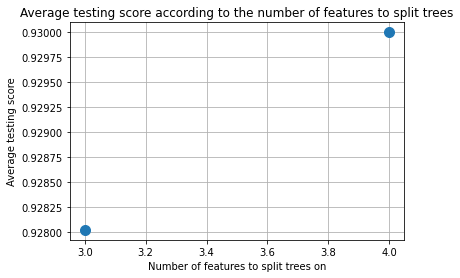

In [186]:
plt.plot(gridsearch_df[['mean_test_score', 'param_max_features']].groupby('param_max_features').mean(), 
         marker='o', linestyle='None', markersize = 10.0)
plt.xlabel('Number of features to split trees on')
plt.ylabel('Average testing score')
plt.title('Average testing score according to the number of features to split trees')
plt.grid()

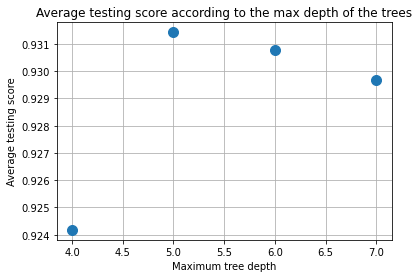

In [187]:
plt.plot(gridsearch_df[['mean_test_score', 'param_max_depth']].groupby('param_max_depth').mean(),
         marker='o', linestyle='None', markersize = 10.0)
plt.xlabel('Maximum tree depth')
plt.ylabel('Average testing score')
plt.title('Average testing score according to the max depth of the trees')
plt.grid()

#### Plot one of the decision trees in the forest

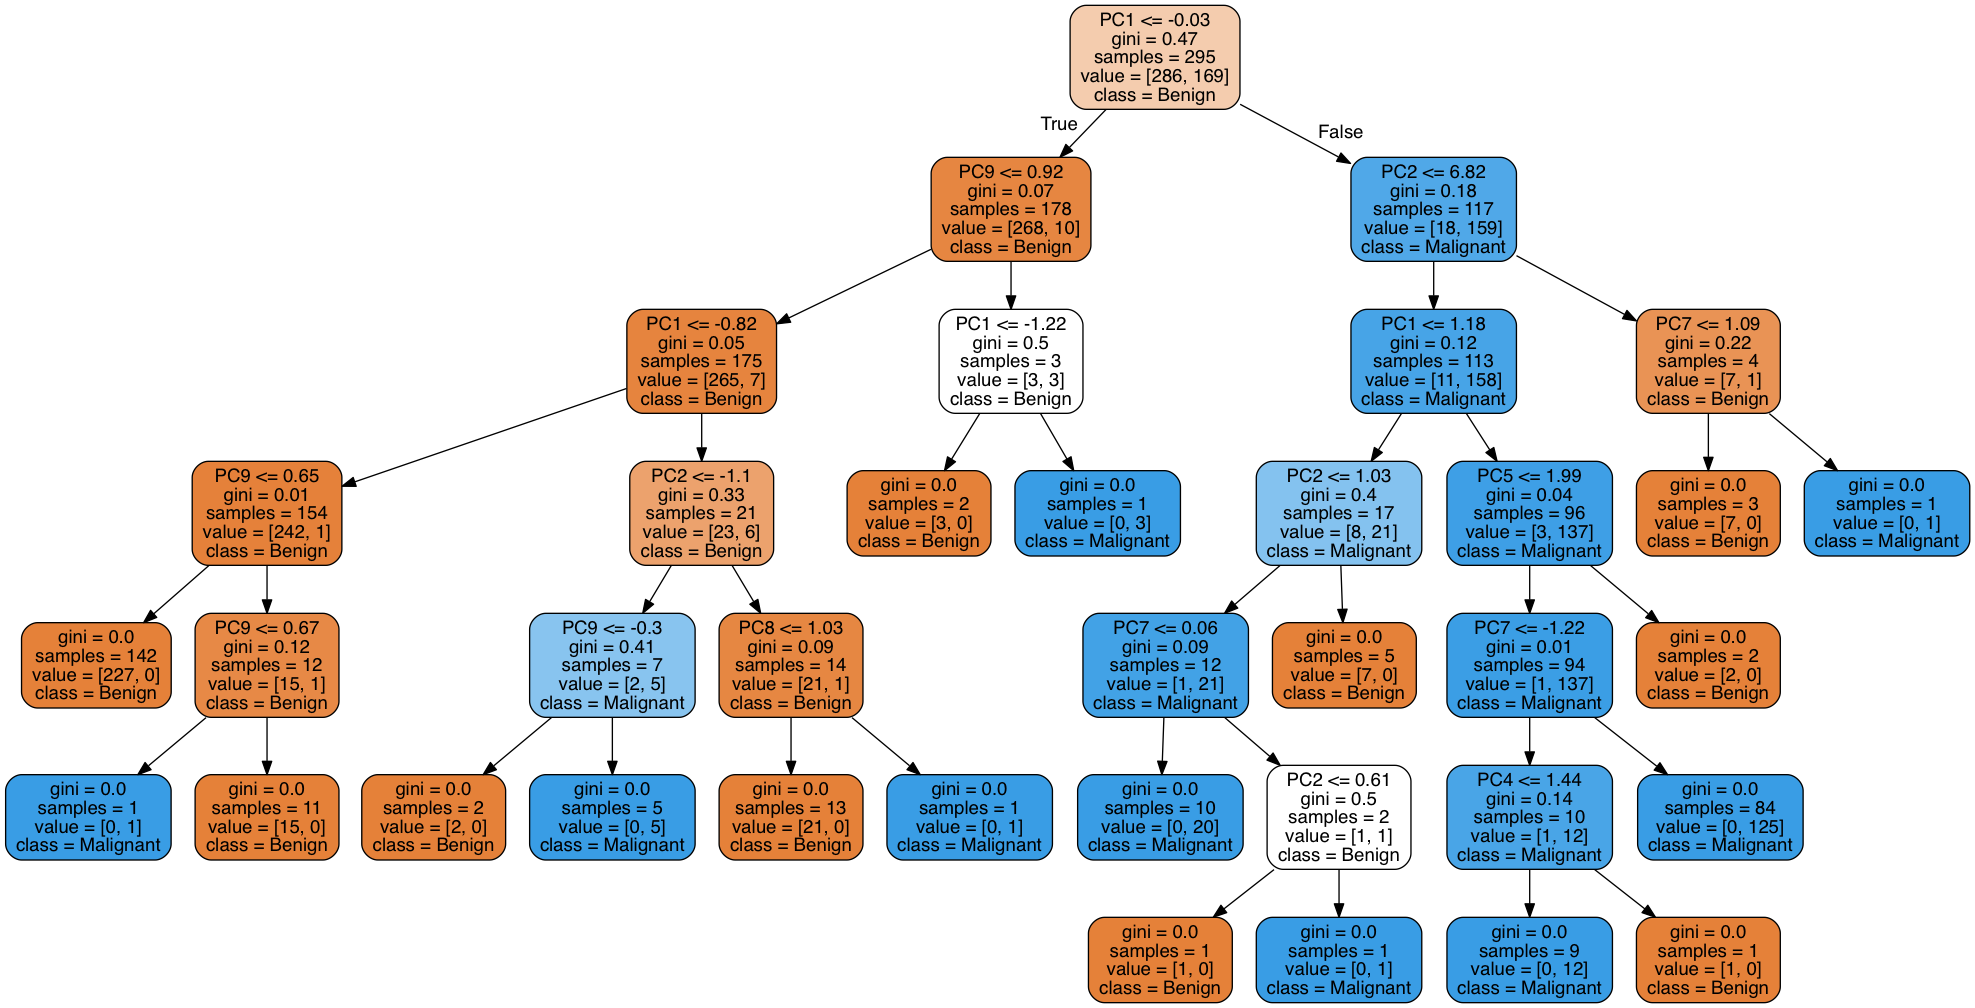

In [188]:
clf_rf = rf_grid.best_estimator_
estimator = clf_rf.estimators_[1]

from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features_pca,
                class_names = ['Benign','Malignant'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Display in jupyter notebook
import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

from IPython.display import Image
Image(filename = 'tree.png')

#### Plot another tree for comparison

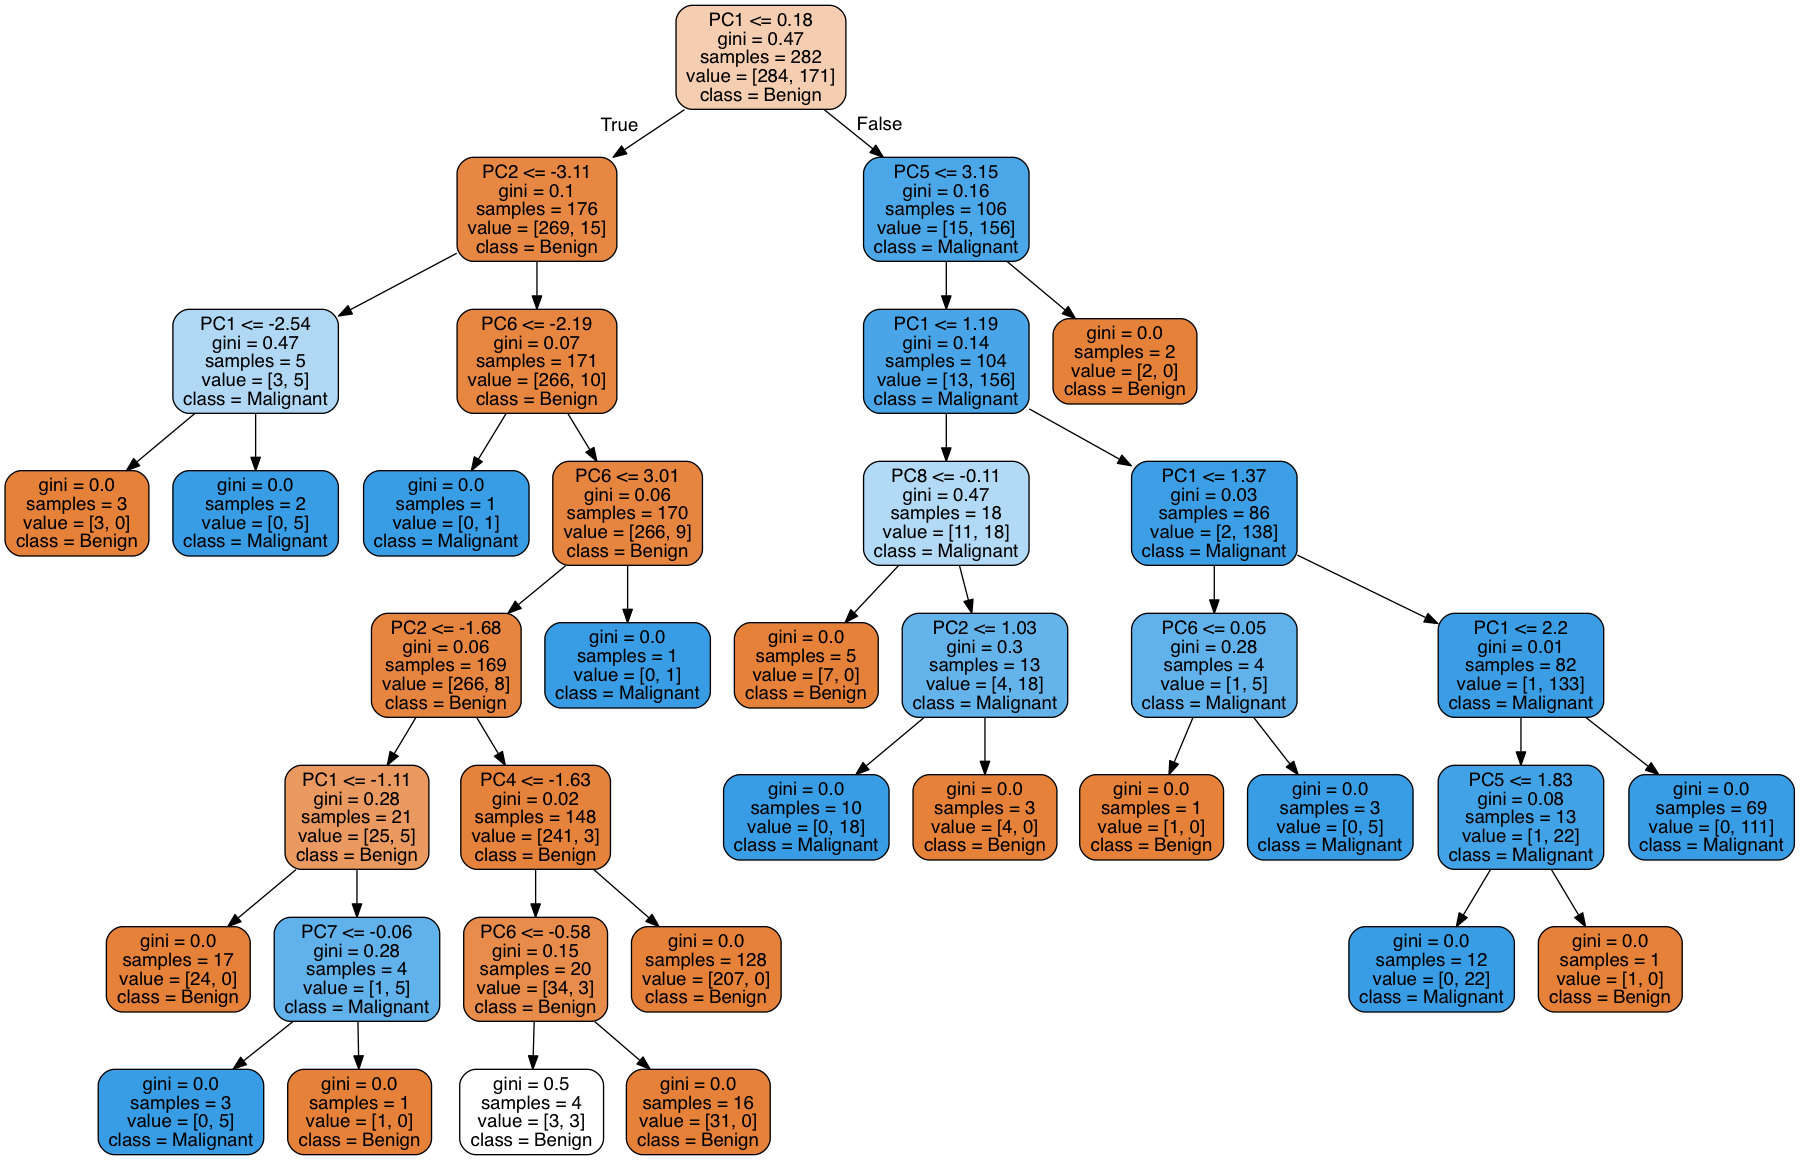

In [241]:
clf_rf = rf_grid.best_estimator_
estimator = clf_rf.estimators_[2]

from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features_pca,
                class_names = ['Benign','Malignant'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Display in jupyter notebook
import pydot

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

from IPython.display import Image
Image(filename = 'tree.png')

### 2.2 SVM

In [222]:
from sklearn.svm import SVC

svm_grid = GridSearchCV(SVC(gamma="auto", random_state = 33), {
    'C':[1,2,3,4,5,6],
    'kernel':['rbf','linear']},
     cv=5)

svm_grid.fit(X_train_pca, y_train)

gridsearch_df_svm = pd.DataFrame(svm_grid.cv_results_).sort_values("rank_test_score", ascending=True)
gridsearch_df_svm = gridsearch_df_svm[["param_C", "param_kernel", "mean_test_score"]].reset_index()
gridsearch_df_svm = gridsearch_df_svm.drop(["index"], axis=1)
gridsearch_df_svm.index = gridsearch_df_svm.index+1
gridsearch_df_svm.head(5)

,param_C,param_kernel,mean_test_score
1,1,linear,0.973626
2,2,rbf,0.969231
3,3,rbf,0.969231
4,1,rbf,0.967033
5,2,linear,0.967033


In [223]:
clf_svm = svm_grid.best_estimator_

#### To present the SVM mechanism, we consider the first two PCs in order to plot the data and the obtained decision boundary 

In [233]:
X_train_subset = X_train_pca[:,0:2]

svm_grid2 = GridSearchCV(SVC(gamma="auto", random_state = 33), {
    'C':[1,2,3,4,5,6],
    'kernel':['rbf','linear']},
     cv=5)

svm_grid2.fit(X_train_subset, y_train)

gridsearch_df_svm = pd.DataFrame(svm_grid2.cv_results_).sort_values("rank_test_score", ascending=True)
gridsearch_df_svm = gridsearch_df_svm[["param_C", "param_kernel", "mean_test_score"]].reset_index()
gridsearch_df_svm = gridsearch_df_svm.drop(["index"], axis=1)
gridsearch_df_svm.index = gridsearch_df_svm.index+1
gridsearch_df_svm.head(5)

clf_svm_subset = svm_grid2.best_estimator_


In [234]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Text(0, 0.5, 'PC2')

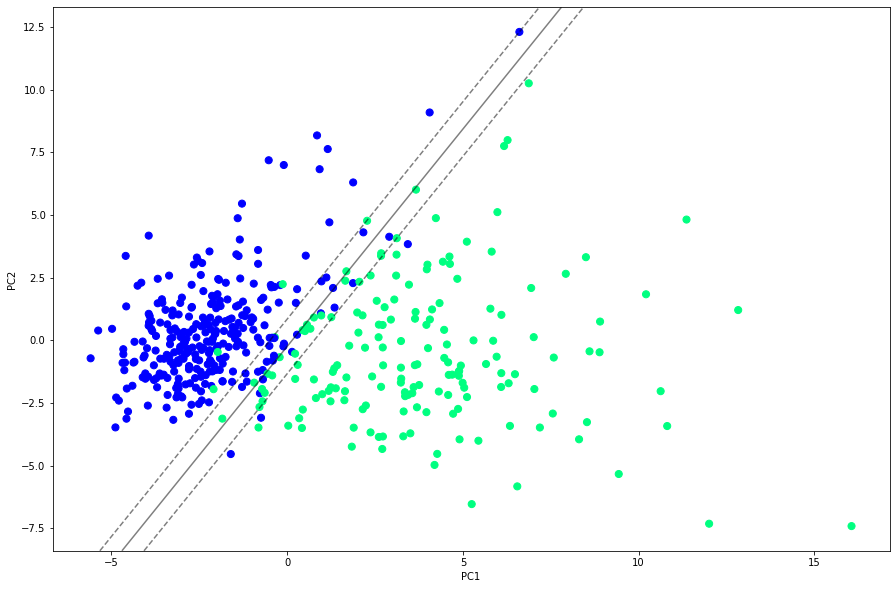

In [243]:
plt.figure(figsize = (15,10))
plt.scatter(X_train_subset[:,0], X_train_subset[:,1], c=y_train, s=50, cmap='winter')
plot_svc_decision_function(clf_svm_subset)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [229]:
clf_svm_subset

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=33, shrinking=True,
  tol=0.001, verbose=False)

## 3. Model comparison

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support


cm_rf = confusion_matrix(y_test, y_pred)
print("Confusion matrix")
print(cm_rf)
print("Confusion Matrix in percentges")
table = pd.crosstab(y_test, pred_logit) / len(y_test)
print(table)


accuracy_rf = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

metrics_rf = precision_recall_fscore_support(y_test, y_pred, average='binary')
print("Random Forest Precision:", metrics_rf[0])
print("Random Forest Recall:", metrics_rf[1])
print("Random Forest FScore:", metrics_rf[2])

### ROC (the code below needs to be updated!)

In [ ]:
# Let's make the predictions and evaluate our model
rf_pred = rf_grid.predict_proba(X_test)[:, 1]
log_pred = log_grid.predict_proba(X_test)[:, 1]
tree_pred = tree_grid.predict_proba(X_test)[:, 1]

# Let's get the false positive rate and the true positive rate, to build our ROC curve
fpr_rf, tpr_rf, _ = roc_curve(target_actual, rf_pred)
fpr_log, tpr_log, _ = roc_curve(target_actual, log_pred)
fpr_tree, tpr_tree, _ = roc_curve(target_actual, tree_pred)

# Plot the ROC curve
fig = plt.figure(figsize=(12,12))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_log, tpr_log, label='Logistic regression')
plt.plot(fpr_tree, tpr_tree, label='Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
#roc curve
auc = roc_auc_score(y_test, pred_logit)
print("AUC : " + str(auc))
fpr, tpr, thresholds = roc_curve(y_test, proba_logit[:,1], pos_label=1)
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='best')
plt.show()

### AUC

In [ ]:
from sklearn.metrics import roc_auc_score

# Predict class probabilities
prob_y = clf_rf.predict_proba(X_test_pca)
 
# Keep only the positive class
prob_y = [p[1] for p in prob_y]

print(roc_auc_score(y_test, prob_y))